## Produce the json file listing all profiles in MED region

In [1]:
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from datetime import date
import io
import json


/home/alberta/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [16]:
jsonfile='MEDWEST60_y2010m02d05-y2010m03d06.json'


In [2]:
latmin,latmax,lonmin,lonmax=(34.84750366,45.13545609,-5.68308401,9.59771824)

In [4]:
datemin=datetime.date(2010,2,5)
datemax=datetime.date(2010,3,6)


In [24]:
def select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax,jsonfile):
    ''' Identify all the EN4 profiles that fall within the selected zone and period
    '''
    # where EN4 is stored on cal1 from lgge194
    diren4="/mnt/alberta/equipes/IGE/meom/workdir/albert/EN4/"
    
    # create a list of daily dates between datemin and datemax
    def date_range(start, end):
        r = (end+datetime.timedelta(days=1)-start).days
        return [start+datetime.timedelta(days=i) for i in range(r)]
    dateList = date_range(datemin, datemax) # list of days between datemin and datemax

    # make a list of the EN4 daily files that corresponds all dates in dateList
    list_filesEN4=[]
    for date in dateList:
        year=date.year
        month=date.month
        day=date.day
        mm="{:02d}".format(month) #month on 2 digits
        dd="{:02d}".format(day) # day on 2 digits
        list_filesEN4.append(str(year)+str(mm)+str(dd)+'_prof.nc')
                          
                          
    # convert datemin and datemax to a number of seconds since 1958
    datetmin=pd.to_datetime(datemin)
    datetmax=pd.to_datetime(datemax)
    ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
    ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
    tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
    tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()

    # for each EN4 daily file selected, find the profiles that are in the [lonmin,lonmax,latmin,latmax] region
    for f in np.arange(len(list_filesEN4)):
        fileEN4=list_filesEN4[f]
        print('Processing '+str(fileEN4))
        tfileEN4=diren4+fileEN4
        #open the file and read the infos on latitude,lon,date and reference, all 1D variables
        dsen4=xr.open_dataset(tfileEN4)
        laten4=dsen4['LATITUDE']
        lonen4=dsen4['LONGITUDE']
        dayen4=dsen4['JULD']
        refen4=dsen4['DC_REFERENCE']
        #find the indices for which the location is in the good region
        indz=np.where((lonmin<lonen4.values)&(lonen4.values<lonmax)&(latmin<laten4.values)&(laten4.values<latmax))
        prof_zone=[]
        tsecen4z=[]
        
        #for each profile selected, check for the date exactly
        for ref in np.arange(len(indz[0])):
            #convert date into seconds from 1958
            dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
            ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
            tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
            #keep only profiles with good date
            if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                prof_zone.append(indz[0][ref])
                tsecen4z.append(tsecen4)
                
        #for the selection of profiles, write infos in a dict
        for ref in np.arange(len(prof_zone)):
            if 'dictyml' in locals():
                up={str(refen4[prof_zone[ref]].values):{'reference':str(refen4[prof_zone[ref]].values),'file':fileEN4,'profile no':int(prof_zone[ref]),'latitude':float(laten4[prof_zone[ref]].values),'longitude':float(lonen4[prof_zone[ref]].values),'date':str(dayen4[prof_zone[ref]].values)}}
                dictyml.update(up)
            else:
                dictyml={str(refen4[prof_zone[ref]].values):{'reference':str(refen4[prof_zone[ref]].values),'file':fileEN4,'profile no':int(prof_zone[ref]),'latitude':float(laten4[prof_zone[ref]].values),'longitude':float(lonen4[prof_zone[ref]].values),'date':str(dayen4[prof_zone[ref]].values)}}

        #write dict in a json file           
        with io.open(jsonfile, 'w', encoding='utf8') as outfile:
            outfile.write(str(json.dumps(dictyml, sort_keys=True,indent=4, separators=(',', ': '))))



In [25]:
select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax,jsonfile)

Processing 20100205_prof.nc
Processing 20100206_prof.nc
Processing 20100207_prof.nc
Processing 20100208_prof.nc
Processing 20100209_prof.nc
Processing 20100210_prof.nc
Processing 20100211_prof.nc
Processing 20100212_prof.nc
Processing 20100213_prof.nc
Processing 20100214_prof.nc
Processing 20100215_prof.nc
Processing 20100216_prof.nc
Processing 20100217_prof.nc
Processing 20100218_prof.nc
Processing 20100219_prof.nc
Processing 20100220_prof.nc
Processing 20100221_prof.nc
Processing 20100222_prof.nc
Processing 20100223_prof.nc
Processing 20100224_prof.nc
Processing 20100225_prof.nc
Processing 20100226_prof.nc
Processing 20100227_prof.nc
Processing 20100228_prof.nc
Processing 20100301_prof.nc
Processing 20100302_prof.nc
Processing 20100303_prof.nc
Processing 20100304_prof.nc
Processing 20100305_prof.nc
Processing 20100306_prof.nc


## Plot the locations of all profiles

In [26]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [27]:
    sourcefile=open(jsonfile,'rU',encoding='utf-8')
    infos=json.load(sourcefile)
    nb_profilesEN4=len(infos)
    list_profiles=infos.keys()

    all_lat=np.zeros((nb_profilesEN4))
    all_lon=np.zeros((nb_profilesEN4))
    
    for prof in np.arange(nb_profilesEN4):
        reference =  str(list(list_profiles)[prof])
        lat_prof = infos[reference]['latitude']
        lon_prof = infos[reference]['longitude']
        all_lat[prof]=lat_prof
        all_lon[prof]=lon_prof


/home/alberta/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [28]:
len(all_lon)

38

In [33]:
def map_profiles_from_jsonfile(all_lat,all_lon):
    


    fig=plt.figure(figsize=(20,15))
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((lonmin, lonmax, latmin, latmax))
    ax.coastlines(resolution="10m")
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.scatter(all_lon, all_lat, c='g', linewidth='0', s=18);
    plt.title('EN4 profiles in MEDWEST60 y2010m02d05-y2010m03d06', size=20);
    plt.savefig('profiles_MEDWEST60_y2010m02d05-y2010m03d06.png')


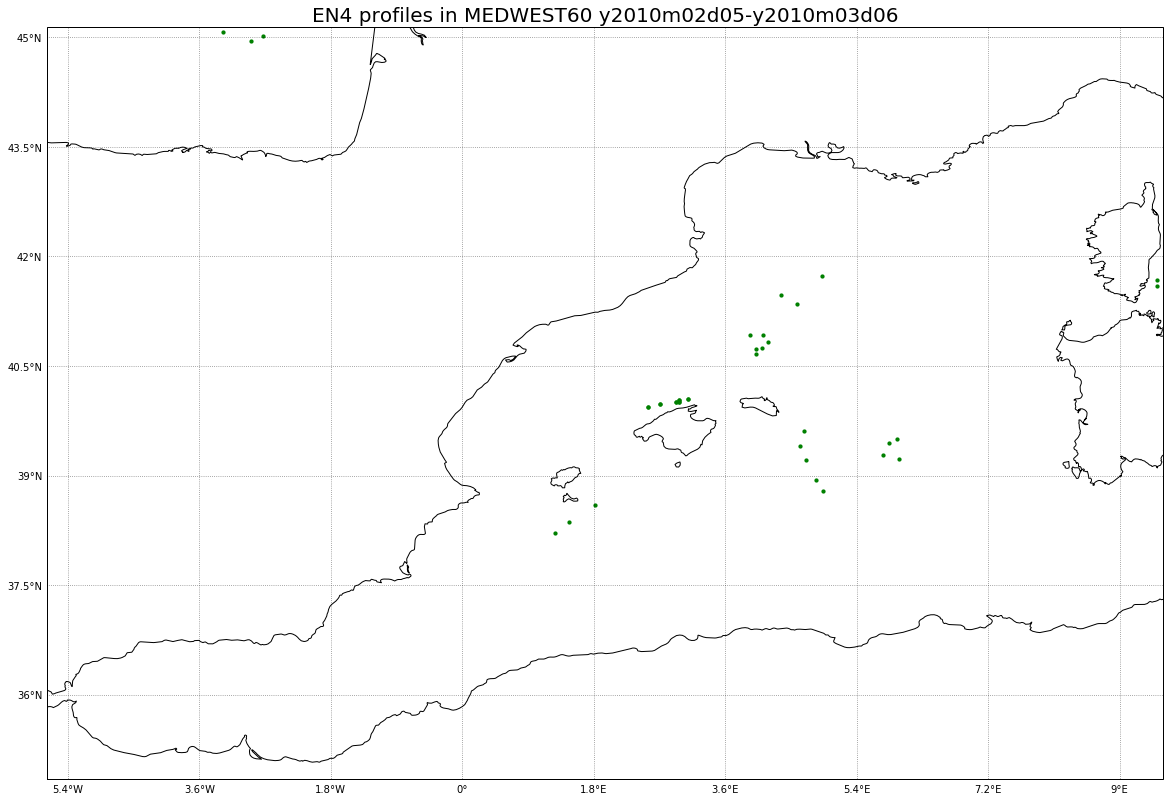

In [34]:
map_profiles_from_jsonfile(all_lat,all_lon)